In [2]:
import pandas as pd
import numpy as np
import torch
import transformers
import datasets
import kss
from sklearn.model_selection import train_test_split

### Load data

In [3]:
df = pd.read_csv("./drive/MyDrive/ko_cover_letter_ai/jobkorea_answer.csv")

train_df, test_df = train_test_split(df, test_size=0.1)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Convert DataFrame to transformers DatasetDict
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

### Preprocessing & Tokenizeing data

#### Load Tokenizer

In [4]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='<s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


#### Add \<unused0> token

In [5]:
def add_special_token_to_answer(data):
    token_answer = []
    for sentence in kss.split_sentences(data['답변']):
        tokenized_sentence = tokenizer.encode(sentence) + tokenizer.encode("<unused0>")
        if len(token_answer) + len(tokenized_sentence) < 512:
            token_answer += tokenized_sentence
        else:
            break
    data['token_answer'] = tokenizer.decode(token_answer)
    # Add answer length
    data['length'] = len(token_answer)
    return data

In [6]:
dataset = dataset.map(add_special_token_to_answer, num_proc=10)

#0:   0%|          | 0/2205 [00:00<?, ?ex/s]

#1:   0%|          | 0/2205 [00:00<?, ?ex/s]

#2:   0%|          | 0/2205 [00:00<?, ?ex/s]

#3:   0%|          | 0/2205 [00:00<?, ?ex/s]

#4:   0%|          | 0/2205 [00:00<?, ?ex/s]

#5:   0%|          | 0/2205 [00:00<?, ?ex/s]

#6:   0%|          | 0/2205 [00:00<?, ?ex/s]

#7:   0%|          | 0/2205 [00:00<?, ?ex/s]

#8:   0%|          | 0/2204 [00:00<?, ?ex/s]

#9:   0%|          | 0/2204 [00:00<?, ?ex/s]

#0:   0%|          | 0/245 [00:00<?, ?ex/s]

#1:   0%|          | 0/245 [00:00<?, ?ex/s]

#2:   0%|          | 0/245 [00:00<?, ?ex/s]

#3:   0%|          | 0/245 [00:00<?, ?ex/s]

#4:   0%|          | 0/245 [00:00<?, ?ex/s]

#5:   0%|          | 0/245 [00:00<?, ?ex/s]

#6:   0%|          | 0/245 [00:00<?, ?ex/s]

#7:   0%|          | 0/245 [00:00<?, ?ex/s]

#8:   0%|          | 0/245 [00:00<?, ?ex/s]

#9:   0%|          | 0/245 [00:00<?, ?ex/s]

#### * Visualize input data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


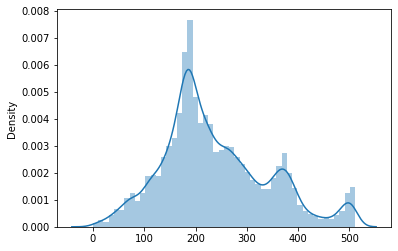

In [7]:
import seaborn as sns

sns.distplot(dataset['train']['length'] + dataset['test']['length'])

#### Tokenize answer

In [8]:
def tokenize_answer(data):
    data = tokenizer(data["token_answer"], padding="max_length", max_length=512, truncation=False)
    data['labels'] = data['input_ids'].copy()
    return data

In [9]:
tokenized_dataset = dataset.map(tokenize_answer, num_proc=5, remove_columns=["답변", "token_answer"])

#0:   0%|          | 0/4410 [00:00<?, ?ex/s]

#1:   0%|          | 0/4410 [00:00<?, ?ex/s]

#2:   0%|          | 0/4410 [00:00<?, ?ex/s]

#3:   0%|          | 0/4409 [00:00<?, ?ex/s]

#4:   0%|          | 0/4409 [00:00<?, ?ex/s]

#0:   0%|          | 0/490 [00:00<?, ?ex/s]

#1:   0%|          | 0/490 [00:00<?, ?ex/s]

#2:   0%|          | 0/490 [00:00<?, ?ex/s]

#3:   0%|          | 0/490 [00:00<?, ?ex/s]

#4:   0%|          | 0/490 [00:00<?, ?ex/s]

### Fine tuning - GPT2

#### Load koGPT2

In [10]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")

Downloading:   0%|          | 0.00/513M [00:00<?, ?B/s]

#### Set Arguments

In [11]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=8, # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    warmup_steps=500, # number of warmup steps for learning rate scheduler
    weight_decay=0.01, # Weight Regularization
    save_steps=4000 # steps model is saved 
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"]
)

#### Training

In [14]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: Unnamed: 0, length. If Unnamed: 0, length are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 22048
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27560


Epoch,Training Loss,Validation Loss
1,1.645500,1.591500
2,1.577100,1.537489
3,1.473800,1.501732
4,1.420400,1.477982
5,1.372800,1.463752
6,1.341600,1.450582
7,1.290700,1.440774
8,1.279000,1.435788
9,1.255900,1.432194
10,1.226400,1.431356


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: Unnamed: 0, length. If Unnamed: 0, length are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2450
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-4000
Configuration saved in test_trainer/checkpoint-4000/config.json
Model weights saved in test_trainer/checkpoint-4000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: Unnamed: 0, length. If Unnamed: 0, length are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2450
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-8000
Configuration saved in test_trainer/checkpoint-8000/config.json
Model weights saved in test_traine

TrainOutput(global_step=27560, training_loss=1.4059566453510168, metrics={'train_runtime': 18423.1555, 'train_samples_per_second': 11.968, 'train_steps_per_second': 1.496, 'total_flos': 5.760966721536e+16, 'train_loss': 1.4059566453510168, 'epoch': 10.0})